# Library

In [434]:
import pandas as pd
import numpy as np
import os
import re
import collections
import unidecode
#from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.corpus import stopwords
import itertools 
from nltk.tokenize import word_tokenize
from string import punctuation

#from nltk import ngrams

#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer

In [435]:
import numpy as np

#import tensorflow_datasets as tfds
#import tensorflow as tf

#from tensorflow.keras import preprocessing
#from tensorflow.keras import layers

#tfds.disable_progress_bar()

In [436]:
#from tensorflow.keras import losses
#from tensorflow.keras import preprocessing
#from tensorflow.keras import utils
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#import tensorflow_datasets as tfds
#import tensorflow_text as tf_text

In [437]:
pd.set_option('display.max_colwidth', 100)

In [438]:
%matplotlib inline
from matplotlib import pyplot as plt

In [439]:
from functools import reduce

# Functions

In [440]:
def read_texts(path):
    data = []
    file_name = os.listdir(path)

    for name in file_name:
        if name.endswith('.txt'):
            with open(path + name,encoding="utf8") as f:
                text = f.read()
                data.append({'nombre':name.replace('.txt',''), 'texto':text})

    df = pd.DataFrame(data)
    return df

In [441]:
def clean_text(string):
    """
    A method to clean text 
    """
    
    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuation:
            if x != '/':
                string = string.replace(x, "")
            else:
                string = string.replace(x, " ")
    
    string = unidecode.unidecode(string)

#     # Converting the text to lower
#     string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in swords])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string 

In [442]:
nltk.download('stopwords')
swords = list(set(stopwords.words('spanish')))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/egarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [443]:
def sep_num_text(data):

    words = word_tokenize(data) 
    for w in words:
        if re.search(r'\d', w):
            ind = words.index(w)
            words[ind] = [''.join(g) for k, g in itertools.groupby(w, str.isalpha)]
    data = ' '.join([x if type(x) is not list else ' '.join(x) for x in words])
    
    return data

In [444]:
def get_f_b_context_text(data):
    
    '''Return context in a string format'''
    
    all_data = []
    sf_not_found = []
    
    for instance in data:
           
        texto = instance['texto']    
        target_word = instance['short_form'] 
        
        if target_word in texto:

            stop_ini_idx = instance['StartOffset'] #índice del inicio de la target
            stop_fin_idx = instance['EndOffset'] #índice del inicio de la target

            _instance = []
            xf = texto[:stop_ini_idx] + ' <start> ' +texto[stop_ini_idx:stop_fin_idx] + ' <end> ' #palabras anteriores a la target
            #xf = texto[:stop_ini_idx] +texto[stop_ini_idx:stop_fin_idx]
            xb = texto[stop_fin_idx+1:]   #palabras posteriores a la target            

            instance_id = instance['long_form'] #id del significado

            _instance.append(target_word)
            _instance.append(xf)
            _instance.append(xb)
            _instance.append(instance_id)

            all_data.append(_instance[:])
        else:
            sf_not_found.append(target_word)
#             print("El acrónimo {} no aparece en el texto {}".format(target_word, instance['doc_id']))
        
    return all_data, sf_not_found

In [445]:
def limit_context(data):

    for doc in data:
        
        sf, xf, xb, lf = doc[0], doc[1], doc[2], doc[3]

        xf_words = word_tokenize(xf)[-n_step_f-1:]
        xb_words = word_tokenize(xb)[:n_step_b]

        doc[1] = ' '.join(xf_words)
        doc[2] = ' '.join(xb_words)   

    return data        

In [446]:
def create_dict(data):
    
    data_dic = []
    
    for instance in data:
            
        dic = {}

        dic['short_form'] = instance[0]
        dic['context'] = instance[1] + ' ' + instance[2]
        dic['long_form'] = instance[3]
    
        data_dic.append(dic)
        
    return data_dic
    

In [447]:
def distance_levenshtein(str1, str2):
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [448]:
def normalize_lf(row):
    leven2 = []
    for i in row:
        for j in row:
            if i != j:
                ratio = distance_levenshtein(i,j)/len(i)
                if ratio < 0.2:
                    leven2.append(j)
    if leven2:
        leven2 = set(leven2)
        lista = []
        for i in leven2:
            val = frec[frec['index'] == i]['long_form'].iloc[0]
            lista.append((i, val))
        lista = set(lista)
        most_freq = sorted(set(lista), key=lambda x: x[1], reverse = True)[0][0]
        sust = {}
        for i in set(leven2):
            sust[i] = most_freq
        
        return sust
    else:
        pass
    

# Load Data

### Testing

220 clinical cases.

In [449]:
testing_abbr = pd.read_csv("../datasets/testing_set/clinical_cases.abbreviations.testing_set.tsv", sep = '\t')
testing_met = pd.read_csv("../datasets/testing_set/clinical_cases.metadata.testing_set.tsv", sep = '\t')
testing_rel = pd.read_csv("../datasets/testing_set/clinical_cases.relations.testing_set.tsv", sep = '\t')

In [450]:
testing_met.head()

,# Document_ID,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1130-01082006000700014-1.txt,1.txt,1130-0108,2006-07-01,Revista Española de Enfermedades Digestivas v.98 n.7 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082006000700014
1,S1130-01082007000300006-7.txt,7.txt,1130-0108,2007-03-01,Revista Española de Enfermedades Digestivas v.99 n.3 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082007000300006
2,S1134-80462009000100005-1.txt,1.txt,1134-8046,2009-02-01,Revista de la Sociedad Española del Dolor v.16 n.1 2009,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1134-80462009000100005
3,S1137-66272014000300015-1.txt,1.txt,1137-6627,2014-12-01,Anales del Sistema Sanitario de Navarra v.37 n.3 2014,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1137-66272014000300015
4,S0365-66912004001200011-1.txt,1.txt,0365-6691,2004-12-01,Archivos de la Sociedad Española de Oftalmología v.79 n.12 2004,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0365-66912004001200011


In [451]:
testing_rel = testing_rel.reset_index()

In [452]:
testing_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [453]:
testing_rel = testing_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [454]:
testing_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S0211-69952013000500019-1,SHORT_FORM,3739,ARA II,SHORT-LONG,LONG_FORM,3695,3737,antagonista del receptor de angiotesina II
1,S0211-69952013000500019-1,SHORT_FORM,2793,PCR,SHORT-LONG,LONG_FORM,2798,2837,reacción en cadena de enzima polimerasa
2,S0365-66912004000600008-1,SHORT_FORM,406,AV,SHORT-LONG,LONG_FORM,390,404,agudeza visual
3,S0211-69952012000500025-1,SHORT_FORM,945,angio-TAC,SHORT-LONG,LONG_FORM,908,943,angiotomografía computarizada axial
4,S1130-05582017000200122-1,SHORT_FORM,940,RMN,SHORT-LONG,LONG_FORM,910,938,resonancia magnética nuclear


In [455]:
testing_rel.Relation_type.unique()

array(['SHORT-LONG', 'SHORT-NESTED', 'NESTED-LONG'], dtype=object)

In [456]:
testing_abbr = testing_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [457]:
testing_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0004-06142010000500014-1,2037,2044,16SrRNA,16s ribosomal rna,16s ribosomal rno
1,S0004-06142010000500014-1,1349,1351,M.,mycobacterium,mycobacterium
2,S0004-06142010000500014-1,1339,1342,PCR,polymerase chain reaction,polymerase chain reaction
3,S0004-06142010000500014-1,611,615,BHCG,beta-human chorionic gonadotropin,beta-humar chorionic gonadotropin
4,S0004-06142010000500014-1,594,597,CEA,carcinoembrionary antigen,carcinoembrionary antiger


In [458]:
testing_raw = read_texts("../datasets/testing_set/testing_set.raw_text/")

In [459]:
testing_raw.head()

,nombre,texto
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d..."
1,S0004-06142009000400011-1,Varón de 75 años con antecedentes de EPOC moderado sin otros antecedentes médicos de interés. En...
2,S0376-78922011000200004-1,Mujer de 44 años de edad con antecedentes médicos de insuficiencia renal crónica en tratamiento ...
3,S1137-66272014000300016-1,Mujer de 36 años sin antecedentes médicos o epidemiológicos de interés que es ingresada en la Un...
4,S1130-01082008000800019-1,"Recientemente, atendimos en nuestro hospital a un varón de 46 años, con antecedente de síndrome ..."


### Development

146 clinical cases

In [460]:
dev_abbr = pd.read_csv("../datasets/development_set/clinical_cases.abbreviations.development_set.tsv", sep = '\t')
dev_met = pd.read_csv("../datasets/development_set/clinical_cases.metadata.development_set.tsv", sep = '\t')
dev_rel = pd.read_csv("../datasets/development_set/clinical_cases.relations.development_set.tsv", sep = '\t')

In [461]:
dev_met = dev_met.rename(columns = {'# Document_ID': 'doc_id'})

In [462]:
dev_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1130-14732005000300004-1.txt,1.txt,1130-1473,2005-06-01,Neurocirugía v.16 n.3 2005,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-14732005000300004
1,S1130-01082008000200009-1.txt,1.txt,1130-0108,2008-02-01,Revista Española de Enfermedades Digestivas v.100 n.2 2008,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082008000200009
2,S1137-66272012000300021-1.txt,1.txt,1137-6627,2012-12-01,Anales del Sistema Sanitario de Navarra v.35 n.3 2012,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1137-66272012000300021
3,S1699-695X2016000200010-1.txt,1.txt,1699-695X,2016-06-01,Revista Clínica de Medicina de Familia v.9 n.2 2016,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1699-695X2016000200010
4,S1130-01082007001100009-1.txt,1.txt,1130-0108,2007-11-01,Revista Española de Enfermedades Digestivas v.99 n.11 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-01082007001100009


In [463]:
dev_rel = dev_rel.reset_index()

In [464]:
dev_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [465]:
dev_rel = dev_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [466]:
dev_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S1888-75462015000400006-1,SHORT_FORM,1436,AP,SHORT-LONG,LONG_FORM,1419,1434,anteroposterior
1,S0210-56912009000700006-2,SHORT_FORM,876,angio-RMN,SHORT-LONG,LONG_FORM,858,874,angiorresonancia
2,S0210-56912009000700006-2,SHORT_FORM,819,RMN,SHORT-LONG,LONG_FORM,789,817,resonancia magnética nuclear
3,S1698-44472005000300015-1,SHORT_FORM,209,ATM,SHORT-LONG,LONG_FORM,177,207,articulación témporomandibular
4,S1698-44472005000300015-1,SHORT_FORM,1125,TC,SHORT-LONG,LONG_FORM,1099,1123,tomografía computerizada


In [467]:
dev_abbr = dev_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [468]:
dev_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S1130-14732005000300004-1,1216,1218,C3,tercera vértebra cervical,tercero vértebra cervical
1,S1130-14732005000300004-1,717,719,C2,segunda vértebra cervical,segundo vértebra cervical
2,S1130-14732005000300004-1,3191,3193,C3,tercera vértebra cervical,tercero vértebra cervical
3,S1130-14732005000300004-1,2867,2869,C3,tercera vértebra cervical,tercero vértebra cervical
4,S1130-14732005000300004-1,2862,2864,C2,segunda vértebra cervical,segundo vértebra cervical


In [469]:
dev_raw = read_texts("../datasets/development_set/development_set.raw_text/")

In [470]:
dev_raw.head()

,nombre,texto
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede..."
1,S0211-69952017000200225-1,"Varón de 41 años, remitido para evaluación por hallazgo de proteinuria. Diagnóstico de HPN en co..."
2,S1139-76322016000300016-2,"Lactante de 1 mes y 29 días, sin antecedentes de interés, que acude a Urgencias de Pediatría tra..."
3,S0004-06142006000900008-1,Mujer de 45 años de edad que acude a la consulta de urología con síndrome miccional e infeccione...
4,S1139-76322015000100014-1,Niña de siete años que acude a Urgencias en época primaveral por un episodio de crisis compleja ...


### Sample test

15 clinical cases

In [471]:
sample_abbr = pd.read_csv("../datasets/sample_set/clinical_cases.abbreviations.sample_set.tsv", sep = '\t')
sample_met = pd.read_csv("../datasets/sample_set/clinical_cases.metadata.sample_set.tsv", sep = '\t')
sample_rel = pd.read_csv("../datasets/sample_set/clinical_cases.relations.sample_set.tsv", sep = '\t')

In [472]:
sample_met = sample_met.rename(columns = {'# Document_ID': 'doc_id'})

In [473]:
sample_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S0004-06142006000900015-1,1,0004-0614,2006-11-01,Archivos Españoles de Urología (Ed. impresa) v.59 n.9 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142006000900015
1,S0004-06142006000600015-1,1,0004-0614,2006-08-01,Archivos Españoles de Urología (Ed. impresa) v.59 n.6 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142006000600015
2,S0004-06142007000700014-1,1,0004-0614,2007-09-01,Archivos Españoles de Urología (Ed. impresa) v.60 n.7 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142007000700014
3,S0004-06142007000900013-1,1,0004-0614,2007-11-01,Archivos Españoles de Urología (Ed. impresa) v.60 n.9 2007,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142007000900013
4,S0004-06142006000200014-1,1,0004-0614,2006-03-01,Archivos Españoles de Urología (Ed. impresa) v.59 n.2 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-06142006000200014


In [474]:
sample_rel = sample_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [475]:
sample_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A_EndOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S0004-06142006000700014-1,SHORT_FORM,926,929,CEA,SHORT-LONG,LONG_FORM,896,924,Antígeno Carcino Embrionario
1,S0004-06142005001000011-1,SHORT_FORM,1626,1629,ROT,SHORT-LONG,LONG_FORM,1600,1624,reflejos osteotendinosos
2,S0004-06142005001000011-1,SHORT_FORM,1715,1718,RMN,SHORT-LONG,LONG_FORM,1685,1713,resonancia magnética nuclear
3,S0004-06142005001000011-1,SHORT_FORM,1663,1666,RCP,SHORT-LONG,LONG_FORM,1639,1661,reflejo cutaneoplantar
4,S0004-06142005001000011-1,SHORT_FORM,1808,1811,LCR,SHORT-LONG,LONG_FORM,1783,1806,líquido cefalorraquídeo


In [476]:
sample_abbr = sample_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [477]:
sample_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0004-06142005001000011-1,1034,1036,Kg,kilogramo,kilogramo
1,S0004-06142005001000011-1,1031,1033,mg,miligramo,miligramo
2,S0004-06142005001000011-1,196,199,IgA,inmunoglobulina a,inmunoglobulina a
3,S0004-06142005001000011-1,2057,2060,LCR,líquido cefalorraquídeo,líquido cefalorraquídeo
4,S0004-06142005001000011-1,1594,1598,EEII,extremidades inferiores,extremidad inferior


In [478]:
sample_raw = read_texts("../datasets/sample_set/sample_set.raw_text/")

In [479]:
sample_raw.head()

,nombre,texto
0,S0004-06142007000600016-2,Paciente varón de 35 años con tumoración en polo superior de teste derecho hallada de manera cas...
1,S0004-06142005001000016-1,Varón de 65 años que consultaba por un síndrome obstructivo infravesical junto con una tumoració...
2,S0004-06142007000600012-1,Paciente: YSS Edad: 32años Raza: Negra. Antecedentes personales: No refiere patologías asociadas...
3,S0004-06142007000900013-1,"Presentamos el caso de un recién nacido de tres días de vida, que acude a urgencias con su madre..."
4,S0004-06142006000900015-1,"Varón de 47 años, sin antecedentes de interés, que es diagnosticado ecográficamente de masa rena..."


### Trainning

318 clinical cases

In [480]:
train_abbr = pd.read_csv("../datasets/trainning_set/clinical_cases.abbreviations.training_set.tsv", sep = '\t')

In [481]:
train_met = pd.read_csv("../datasets/trainning_set/clinical_cases.metadata.training_set.tsv", sep = '\t')
train_rel = pd.read_csv("../datasets/trainning_set/clinical_cases.relations.training_set.tsv", sep = '\t')

In [482]:
train_met = train_met.rename(columns = {'# Document_ID': 'doc_id'})

In [483]:
train_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1139-76322015000500009-1.txt,1.txt,1139-7632,2015-12-01,Pediatría Atención Primaria v.17 n.68 2015,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1139-76322015000500009
1,S1130-05582008000400007-2.txt,2.txt,1130-0558,2008-08-01,Revista Española de Cirugía Oral y Maxilofacial v.30 n.4 2008,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-05582008000400007
2,S0210-48062006000100012-1.txt,1.txt,0210-4806,2006-01-01,Actas Urológicas Españolas v.30 n.1 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0210-48062006000100012
3,S0213-12852003000500002-1.txt,1.txt,0213-1285,2003-10-01,Avances en Odontoestomatología v.19 n.5 2003,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0213-12852003000500002
4,S0212-71992005000400007-1.txt,1.txt,0212-7199,2005-04-01,Anales de Medicina Interna v.22 n.4 2005,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-71992005000400007


In [484]:
train_rel = train_rel.reset_index()

In [485]:
train_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [486]:
train_rel = train_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [487]:
train_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S1130-01082009000400014-1,SHORT_FORM,476,NPT,SHORT-LONG,LONG_FORM,454.0,474.0,nutrición parenteral
1,S1130-63432016000100009-1,SHORT_FORM,614,NIHSS,SHORT-LONG,LONG_FORM,621.0,662.0,National Institute of Health Stroke Scale
2,S1139-76322017000200007-1,SHORT_FORM,1145,CMV,SHORT-LONG,LONG_FORM,1128.0,1143.0,citomegalovirus
3,S1139-76322017000200007-1,SHORT_FORM,1243,VSG,SHORT-LONG,LONG_FORM,1206.0,1241.0,velocidad de sedimentación globular
4,S1139-76322017000200007-1,SHORT_FORM,1300,IGRA,SHORT-LONG,LONG_FORM,1267.0,1298.0,interferon-gamma release assays


In [488]:
train_abbr = train_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [489]:
train_abbr.Definition.nunique()

908

In [490]:
train_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0210-48062004000500008-1,1650,1652,ml,mililitro,mililitro
1,S0210-48062004000500008-1,708,709,l,litro,litro
2,S0210-48062004000500008-1,704,707,mEq,miliequivalente,miliequivalente
3,S0210-48062004000500008-1,677,681,pCO2,presión parcial de co2,presión parcial de co2
4,S0210-48062004000500008-1,2287,2290,HLA,human leucocyte antigen,human leucocyte antiger


In [491]:
train_raw = read_texts("../datasets/trainning_set/training_set.raw_text/")

In [492]:
train_raw = train_raw.rename(columns = {'nombre': 'doc_id'})

In [493]:
train_raw.head()

,doc_id,texto
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec..."
1,S1130-01082009000300015-1,"Varón de 70 años, fumador, con enfisema pulmonar y vitíligo al que en mayo de 2001 se realizó un..."
2,S0210-56912010000200009-1,Se trata de una mujer de 70 años con antecedentes de HTA y diagnosticada recientemente de neopla...
3,S1130-01082008000900014-1,Varón de 41 años diagnosticado de adenocarcinoma medianamente diferenciado implantado sobre esóf...
4,S0210-48062004000500008-1,Paciente de 29 años de edad que acude al Servicio de Urgencias de nuestro Hospital ante la prese...


In [494]:
train_abbr[train_abbr['Abbreviation']=='TAC']['Definition_lemmatized'].unique()

array(['tomografía axial computarizado',
       'tomografia axial copmputarizado',
       'tomografia axial computarizado', 'tomografía axial computerizado',
       'tomografía axial computadorizado'], dtype=object)

## Prepare Train Data

### Preprocessing

In [495]:
#train = train_raw.merge(train_abbr[['doc_id', 'Abbreviation', 'Definition_lemmatized']], on = 'doc_id', how = 'left')
train = train_raw.merge(train_abbr[['doc_id', 'Abbreviation', 'Definition']], on = 'doc_id', how = 'left')

In [496]:
train = train.merge(train_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [497]:
train = train.drop_duplicates()

In [498]:
#train = train[['doc_id', 'texto', 'Abbreviation', 'Definition_lemmatized_x', 'StartOffset', 'EndOffset']]
train = train[['doc_id', 'texto', 'Abbreviation', 'Definition_x', 'StartOffset', 'EndOffset']]

In [499]:
#train = train.rename(columns = {'Definition_lemmatized_x':'Definition'})
train = train.rename(columns = {'Definition_x':'Definition'})

In [500]:
train.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908.0,1910.0
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684.0,1686.0
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656.0,1658.0
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414.0,1416.0
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654.0,1655.0


In [501]:
train = train.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [502]:
train = train.dropna(subset = ['short_form', 'long_form'])

In [503]:
train[['StartOffset', 'EndOffset']] = train[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [504]:
train['long_form'] = train['long_form'].map(clean_text)

### Normalize long forms

In [505]:
sf_lf = train[['short_form', 'long_form']].drop_duplicates()

In [506]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len', ascending = False)

,short_form,long_form,len
48,AST,"[aspartate aminotransferase, aspartatoaminotransferasa, aspartate and alanine aminotransferase, ...",5
481,PCR,"[proteina c reactiva, polymerase chain reaction, reaccion cadena polimerasa, parada cardiorrespi...",4
573,TAC,"[tomografia axial computarizada, tomografia axial computerizada, tomografia axial computadorizad...",4
273,GGT,"[gammaglutamiltranspeptidasa, gamma glutamil transpeptidasa, gammaglutamil transpeptidasa, gama ...",4
238,FA,"[fluorescein angiography, fosfatasa alcalina, autofluorescencia fondo, fibrilacion auricular]",4
...,...,...,...
275,GLA,[galactosidasa],1
278,GRE,[gradientecho],1
279,GRP,[gastrostomia radiologica percutanea],1
280,Ga-67,[galio67],1


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [507]:
frec = train['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,404
1,decilitro,289
2,centimetro,235
3,litro,215
4,mililitro,180
...,...,...
776,linfoma pulmonar primario,1
777,interleucina 28,1
778,antinuclear antibodies,1
779,fosfatasas alcalinas,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [508]:
norm = []
for i in sf_lf_list['long_form']:
    norm.append(normalize_lf(i))

In [509]:
norm = [i for i in norm if i != None]

In [510]:
norm_dict = {}
for i in norm:
    norm_dict.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [511]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


In [512]:
train = train.replace({"long_form": norm_dict})

Check that deffinitions have been normalized

In [513]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


In [514]:
train[train['long_form'] == 'aspartato transaminasar']

,doc_id,texto,short_form,long_form,StartOffset,EndOffset


In [515]:
train[train['short_form'] == 'tac']['long_form'].unique()

array([], dtype=object)

In [516]:
train_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0210-48062004000500008-1,1650,1652,ml,mililitro,mililitro
1,S0210-48062004000500008-1,708,709,l,litro,litro
2,S0210-48062004000500008-1,704,707,mEq,miliequivalente,miliequivalente
3,S0210-48062004000500008-1,677,681,pCO2,presión parcial de co2,presión parcial de co2
4,S0210-48062004000500008-1,2287,2290,HLA,human leucocyte antigen,human leucocyte antiger


In [517]:
train_abbr[train_abbr['Abbreviation'] == 'AST']['Definition'].unique()

array(['aspartato-aminotransferasa',
       'aspartate and alanine aminotransferase ',
       'aspartato transaminasa', 'aspartate aminotransferase',
       'aspartato aminotransferasa',
       'aspartate and alanine aminotransferase'], dtype=object)

In [518]:
train[train['short_form'] == 'ALT']['long_form'].unique()

array(['alanine transaminase', 'alanine transferase',
       'alanina aminotransferasa'], dtype=object)

### Get just ambigous acronyms

In [519]:
#amb = train.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

In [520]:
#amb.head()

In [521]:
#table = pd.crosstab(amb['long_form'], columns = 'Count')
#table.plot.bar()
#plt.show()

In [522]:
#defin = amb[amb['long_form'] != 1]['short_form'].values.tolist()

In [523]:
#train.shape

In [524]:
#train = train[train['short_form'].isin(defin)]

In [525]:
#train.shape

### Add texts from Medline

Some long forms are imbalanced. Texts from Medline are added to improve balance.

In [526]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


Study imbalaced long forms. Number of rows for each different definition. We can see mostly long forms have just one row.

In [527]:
frec2 = train['long_form'].value_counts().reset_index()

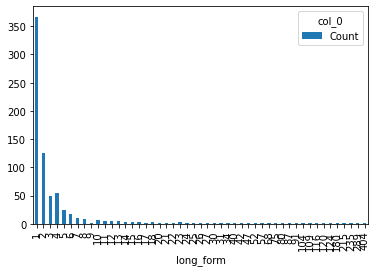

In [528]:
table = pd.crosstab(frec2['long_form'], columns = 'Count')
table.plot.bar()
plt.show()

In [529]:
frec2[frec2['long_form'] == 1].head()

,index,long_form
368,nephrosis 2,1
369,neutrofilo,1
370,glasgow coma scale,1
371,histiocitosis celulas langerhans,1
372,tropical spastic paraparesis,1


In [530]:
train[train['long_form'] == 'sistema nervioso central']

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
648,S1130-01082007000400016-1,Remitimos el caso de una paciente de 73 años que consulta por ictericia y síndrome constituciona...,SNC,sistema nervioso central,1423,1426


In [531]:
train[train['short_form'] == 'SNC']

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
648,S1130-01082007000400016-1,Remitimos el caso de una paciente de 73 años que consulta por ictericia y síndrome constituciona...,SNC,sistema nervioso central,1423,1426
1626,S0211-69952014000200018-1,"Se trata de un varón de un mes de vida, de origen marroquí, que acude a Urgencias por presentar ...",SNC,sindrome nefrotico congenito,1099,1102


Let's find more text for definitions with 3 or less rows in train dataset.

In [532]:
train_lf = train.groupby('long_form').size().reset_index().rename(columns={0:'count'}).sort_values('count')
train_lf_list = train_lf[train_lf['count'] <= 3]['long_form'].unique().tolist()

In [533]:
len(train_lf_list)

542

List of deffinition to search in Medline

In [534]:
sorted(train_lf_list)

['533dimethyl1triazenoimidazole4carboxamide',
 '5fluorouracilo',
 '99 metilendifosfonato',
 'acido acetil salicilico',
 'acido dexosirribonucleico',
 'acido folinico fluorouracilo oxaliplatino',
 'acido graso esencial',
 'acidos grasos cadena media',
 'acute therapy service',
 'adenina',
 'adenosin aminasa',
 'adriamicina',
 'adriamicina bleomicina vinblastina dacarbacina',
 'agudeza visual correccion',
 'aktiebolag',
 'alanina aminotransferasa',
 'alanine',
 'alanine transaminase',
 'alaninoaminotransferasa',
 'albinismo oculocutaneo',
 'alfagalactosidasa',
 'alkaline phosphatase',
 'american medical association',
 'american society for parenteral and enteral nutrition',
 'amiloide p',
 'amiloidosis primaria',
 'analisis inmunoabsorcion ligado enzimas',
 'anaplastic lymphoma kinase',
 'anatomia patologica',
 'angiofluoresceingrafia',
 'angioresonancia magnetica',
 'anion bicarbonato',
 'antagonista vitamina',
 'anteroposterior',
 'anticuerpo',
 'anticuerpo citoplasmatico antineutrofil

#### Medline texts

In [535]:
medline = pd.read_csv("data/textos_medline_scrapping2.csv")
medline.head()

,Unnamed: 0,url,text,concept
0,0,https://medlineplus.gov/spanish/mercury.html,"\n\nEl mercurio es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias...",mercurio
1,1,https://medlineplus.gov/spanish/ency/article/002476.htm,Este artículo aborda la intoxicación por mercurio.Este artículo es solamente informativo. NO lo ...,mercurio
2,2,https://medlineplus.gov/spanish/ency/article/002475.htm,Es una de las formas de mercurio. También es un tipo de sal de mercurio. Hay tipos diferentes de...,mercurio
3,3,https://medlineplus.gov/spanish/ency/article/002474.htm,El cloruro de mercurio es una forma muy tóxica de este elemento. Se trata de un tipo de sal de m...,mercurio
4,4,https://medlineplus.gov/spanish/ency/article/007763.htm,Es el daño al cerebro y al sistema nervioso causado por el químico metilmercurio. Este artículo ...,mercurio


In [536]:
medline[medline['concept'].isin(train_lf_list)]['concept'].nunique()

27

Justo 30 deffinition have been fine in Medline

In [537]:
medline[medline['concept'].isin(train_lf_list)].shape

(564, 4)

In [538]:
medline[medline['concept'].isin(train_lf_list)].head()

,Unnamed: 0,url,text,concept
0,0,https://medlineplus.gov/spanish/mercury.html,"\n\nEl mercurio es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias...",mercurio
1,1,https://medlineplus.gov/spanish/ency/article/002476.htm,Este artículo aborda la intoxicación por mercurio.Este artículo es solamente informativo. NO lo ...,mercurio
2,2,https://medlineplus.gov/spanish/ency/article/002475.htm,Es una de las formas de mercurio. También es un tipo de sal de mercurio. Hay tipos diferentes de...,mercurio
3,3,https://medlineplus.gov/spanish/ency/article/002474.htm,El cloruro de mercurio es una forma muy tóxica de este elemento. Se trata de un tipo de sal de m...,mercurio
4,4,https://medlineplus.gov/spanish/ency/article/007763.htm,Es el daño al cerebro y al sistema nervioso causado por el químico metilmercurio. Este artículo ...,mercurio


In [539]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


Transform Medline text with train structure

In [540]:
med_texts = medline[medline['concept'].isin(train_lf_list)]

In [541]:
med_texts = med_texts[['text', 'concept']].rename(columns = {'text':'texto', 'concept':'long_form'})

In [542]:
sf_lf = train[train['long_form'].isin(train_lf_list)][['short_form', 'long_form']].set_index('long_form').to_dict()['short_form']

In [543]:
med_texts['short_form'] = med_texts['long_form'].map(sf_lf)

In [544]:
def replace_sf_lf(row):
    row['texto'] = row['texto'].replace(row['long_form'], row['short_form'])
    return row['texto']

In [545]:
med_texts['texto'] = med_texts.apply(replace_sf_lf, axis = 1)

In [546]:
med_texts.head()

,texto,long_form,short_form
0,"\n\nEl Hg es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias forma...",mercurio,Hg
1,Este artículo aborda la intoxicación por Hg.Este artículo es solamente informativo. NO lo use pa...,mercurio,Hg
2,Es una de las formas de Hg. También es un tipo de sal de Hg. Hay tipos diferentes de intoxicació...,mercurio,Hg
3,El cloruro de Hg es una forma muy tóxica de este elemento. Se trata de un tipo de sal de Hg. Hay...,mercurio,Hg
4,Es el daño al cerebro y al sistema nervioso causado por el químico metilHg. Este artículo es sol...,mercurio,Hg


In [547]:
def find_offset(row):
    start_i = row['texto'].find(row['short_form'])
    end_i = start_i + len(row['short_form'])
    
    return start_i, end_i   

In [548]:
med_texts['offsets'] = med_texts.apply(find_offset, axis = 1)

In [549]:
med_texts[['StartOffset', 'EndOffset']] = pd.DataFrame(med_texts['offsets'].tolist(), index=med_texts.index)

In [550]:
med_texts = med_texts[['texto', 'short_form', 'long_form','StartOffset', 'EndOffset']]

In [551]:
med_texts.head()

,texto,short_form,long_form,StartOffset,EndOffset
0,"\n\nEl Hg es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias forma...",Hg,mercurio,5,7
1,Este artículo aborda la intoxicación por Hg.Este artículo es solamente informativo. NO lo use pa...,Hg,mercurio,41,43
2,Es una de las formas de Hg. También es un tipo de sal de Hg. Hay tipos diferentes de intoxicació...,Hg,mercurio,24,26
3,El cloruro de Hg es una forma muy tóxica de este elemento. Se trata de un tipo de sal de Hg. Hay...,Hg,mercurio,14,16
4,Es el daño al cerebro y al sistema nervioso causado por el químico metilHg. Este artículo es sol...,Hg,mercurio,72,74


Concat train and Medline texts

In [552]:
train.shape

(4866, 6)

In [553]:
train = pd.concat([train, med_texts], axis = 0)

In [554]:
train.shape

(5430, 6)

In [555]:
train.reset_index(inplace = True, drop = True)
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
4,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


Check how many deffinition have low texts

In [556]:
frec3 = train['long_form'].value_counts().reset_index()

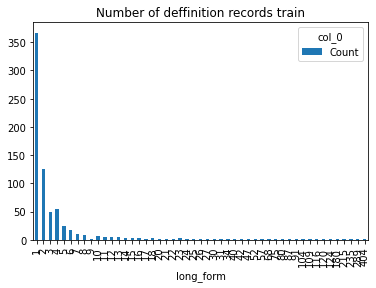

In [557]:
table = pd.crosstab(frec2['long_form'], columns = 'Count')
table.plot.bar()
plt.title('Number of deffinition records train')
plt.show()

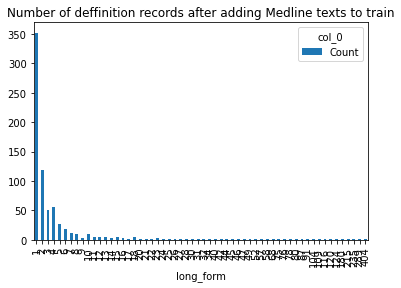

In [558]:
table = pd.crosstab(frec3['long_form'], columns = 'Count')
table.plot.bar()
plt.title('Number of deffinition records after adding Medline texts to train')
plt.show()

Transform dataframe to a list of dictionaries

In [559]:
train_data = train[['doc_id', 'texto', 'short_form', 'long_form', 'StartOffset', 'EndOffset']].to_dict('records')

### Get the text before and after the SF

In [560]:
train_ndata, sf_not_found = get_f_b_context_text(train_data)

Check if any SF is not founded in the text

In [561]:
sf_not_found_set = set(sf_not_found)

In [562]:
len(sf_not_found_set)

15

Now clean the texts, remove string punctuation, accents, lower case, remove double spaces, separate numbers from sf

In [563]:
# def clean_text_after(data):
    
#     for instance in data:
#         instance[1] = clean_text(instance[1]).lower()
#         instance[2] = clean_text(instance[2]).lower()
#         instance[1] = re.sub(r'(\d+)', r'\g<1> ', instance[1]) #metemos espacio entre número y acrónimos que quedan pegados    
#         instance[2] = re.sub(r'(\d+)', r'\g<1> ', instance[2])
#         instance[1] = re.sub(r'\s+', ' ', instance[1]).strip()
#         instance[2] = re.sub(r'\s+', ' ', instance[2]).strip()
#     return data
        

In [564]:
# train_ndata = clean_text_after(train_ndata)

### Get the contexts 

From the texts before and after the sf, we limit the number of words

In [565]:
star_ends_tokens = 6 #number of tokens to add because <start> and <end> labels 

In [566]:
n_step_f = 10 + star_ends_tokens #number of words to select from the forward context
n_step_b = 10 #number of words to select from the backward context

In [567]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/egarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [568]:
train_ndata = limit_context(train_ndata)

In [569]:
train_ndata[0]

['dl',
 'del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end >',
 '960 células/mm3 un 90 % de las cuales se correspondían',
 'decilitro']

### Transform into df grouped by LF

In [570]:
data_dic = create_dict(train_ndata)

In [571]:
data_df = pd.DataFrame(data_dic)

Asign an id to each LF

In [572]:
data_df = data_df.assign(id=(data_df['long_form']).astype('category').cat.codes)

In [573]:
data_df.head()

,short_form,context,long_form,id
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,191
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,191
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,191
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,191
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,313


In [574]:
data_df.shape

(5228, 4)

Vamos a unir cada SF con todas las posibles LF, una por cada registro, para que posteriormente el modelo funcione de forma binaria asignando la probabilidad de que ese sea su LF

In [575]:
sf_lf_unique = data_df[['short_form', 'long_form']].drop_duplicates()

In [576]:
sf_lf_unique.shape

(835, 2)

In [577]:
sf_lf_unique.sort_values('short_form').head()

,short_form,long_form
4324,5-FU,5fluorouracilo
962,67Ga,gallium67
1802,99-MDP,99 metilendifosfonato
964,99Tc,tecnecio99
1557,A,adenina


In [578]:
data_merged = data_df.merge(sf_lf_unique, on = 'short_form', how = 'left')

In [579]:
data_merged.shape

(7297, 5)

In [580]:
pd.set_option('display.max_colwidth', 100)

In [581]:
data_df.sort_values(['short_form', 'context']).head()

,short_form,context,long_form,id
4326,5-FU,"1 , leucovorin 200 mg/m2 i.v . día 1 , < start > 5-FU < end > 400 mg/m2 en bolo i.v . día 1 , 5-FU",5fluorouracilo,1
4324,5-FU,"5-FU 400 mg/m2 en bolo i.v . día 1 , < start > 5-FU < end > 1.200 mg/m2/día en perfusión continu...",5fluorouracilo,1
4325,5-FU,"generalizada y alopecia , ambos relacionados con la toxicidad del < start > 5-FU < end > Pese a ...",5fluorouracilo,1
962,67Ga,"la cabeza femoral izquierda confirmada por TAC , 99Tc y < start > 67Ga < end > gammagrafía . La ...",gallium67,293
1802,99-MDP,realizado un estudio completo que incluyó gammagrafía ósea con tecnecio < start > 99-MDP < end >...,99 metilendifosfonato,2


In [582]:
data_merged.sort_values(['short_form', 'context']).head()

,short_form,context,long_form_x,id,long_form_y
5805,5-FU,"1 , leucovorin 200 mg/m2 i.v . día 1 , < start > 5-FU < end > 400 mg/m2 en bolo i.v . día 1 , 5-FU",5fluorouracilo,1,5fluorouracilo
5803,5-FU,"5-FU 400 mg/m2 en bolo i.v . día 1 , < start > 5-FU < end > 1.200 mg/m2/día en perfusión continu...",5fluorouracilo,1,5fluorouracilo
5804,5-FU,"generalizada y alopecia , ambos relacionados con la toxicidad del < start > 5-FU < end > Pese a ...",5fluorouracilo,1,5fluorouracilo
1275,67Ga,"la cabeza femoral izquierda confirmada por TAC , 99Tc y < start > 67Ga < end > gammagrafía . La ...",gallium67,293,gallium67
2494,99-MDP,realizado un estudio completo que incluyó gammagrafía ósea con tecnecio < start > 99-MDP < end >...,99 metilendifosfonato,2,99 metilendifosfonato


El label debe de ser 0 o 1, es decir, si la LF que le corresponde es la que se le asigna. Por ello creamos una etiqueta binaria.

In [583]:
def get_label(row):
    if row['long_form_x'] == row['long_form_y']:
        return 1
    else:
        return 0

In [584]:
data_merged['label'] = data_merged.apply(get_label, axis = 1)

In [585]:
data_merged.head()

,short_form,context,long_form_x,id,long_form_y,label
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,191,decilitro,1
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,191,decilitro,1
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,191,decilitro,1
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,191,decilitro,1
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,313,gramo,1


In [586]:
data_merged = data_merged[['short_form', 'context', 'long_form_y', 'label']]

In [587]:
data_merged = data_merged.rename(columns = {'long_form_y':'long_form'})

In [588]:
data_merged.reset_index(drop = True, inplace = True)

In [589]:
data_merged.head()

,short_form,context,long_form,label
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,1
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,1
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,1
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,1
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,1


In [590]:
data_merged.to_csv('data/data_train/train_data_beto_10_NOamb_lfnorm_medline.csv')

## Prepare Test Data

### Preprocessing

In [591]:
testing_raw.rename(columns={'nombre':'doc_id'}, inplace = True)

In [592]:
test = testing_raw.merge(testing_abbr[['doc_id', 'Abbreviation', 'Definition_lemmatized']], on = 'doc_id', how = 'left')

In [593]:
test = test.merge(testing_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [594]:
test = test.drop_duplicates()

In [595]:
test = test[['doc_id', 'texto', 'Abbreviation', 'Definition_lemmatized_x', 'StartOffset', 'EndOffset']]

In [596]:
test = test.rename(columns = {'Definition_lemmatized_x':'Definition'})

In [597]:
test.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",PAI,pancreatitis autoinmunir,2502.0,2505.0
1,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SLA,anti-soluble liver antiger,702.0,705.0
2,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SMA,smooth muscle actin,697.0,700.0
3,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",LKM1,liver-kidney microsomal type 1,691.0,695.0
4,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",ANCA,antineutrophil cytoplasmic antibodie,685.0,689.0


In [598]:
test = test.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [599]:
test = test.dropna(subset = ['short_form', 'long_form'])

In [600]:
test[['StartOffset', 'EndOffset']] = test[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [601]:
test['long_form'] = test['long_form'].map(clean_text)

### Normalize long forms

In [602]:
sf_lf_test = test[['short_form', 'long_form']].drop_duplicates()

In [603]:
sf_lf_list_test = sf_lf_test.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list_test['len'] = sf_lf_list_test['long_form'].map(lambda x: len(x))
sf_lf_list_test.sort_values('len', ascending = False)

,short_form,long_form,len
87,C3,"[tercero componente complemento, tercero vertebra cervical, complemento 3, nivel c subnivel 3]",4
241,G,"[gauge, guanine, guanina]",3
215,F,"[filamentous, fenilalanina, french]",3
481,T,"[treonina, thymus, onda t]",3
416,PL,"[puncion lumbar, percepcion luz, periodo lavado]",3
...,...,...,...
252,GOT,[glutamic oxalic transaminar],1
253,GPL,[g fosfolipido],1
254,GPT,[glutamate pyruvatar transaminar],1
255,GQ-1b,[antigangliosidir antibodie 1b],1


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [604]:
frec = test['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,361
1,decilitro,213
2,centimetro,171
3,litro,128
4,mililitro,117
...,...,...
673,americar joint committeer cancer,1
674,3 dimension,1
675,proteina 53,1
676,chlamydia,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [605]:
norm_test = []
for i in sf_lf_list_test['long_form']:
    norm_test.append(normalize_lf(i))

In [606]:
norm_test = [i for i in norm_test if i != None]

In [607]:
norm_dict_test = {}
for i in norm_test:
    norm_dict_test.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [608]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
4,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


In [609]:
test = test.replace({"long_form": norm_dict_test})

In [610]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
4,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


### Get just ambigous acronyms

In [611]:
#amb_test = test.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

In [612]:
#amb_test.head()

In [613]:
#table = pd.crosstab(amb_test['long_form'], columns = 'Count')
#table.plot.bar()
#plt.show()

In [614]:
#defin_test = amb_test[amb_test['long_form'] != 1]['short_form'].values.tolist()

In [615]:
#test.shape

In [616]:
#test = test[test['short_form'].isin(defin_test)]

In [617]:
#test.shape

Transform dataframe to a list of dictionaries

In [618]:
test_data = test[['doc_id', 'texto', 'short_form', 'long_form', 'StartOffset', 'EndOffset']].to_dict('records')

### Get the text before and after the SF

In [619]:
test_ndata, sf_not_found = get_f_b_context_text(test_data)

Check if any SF is not founded in the text

In [620]:
sf_not_found_set = set(sf_not_found)

In [621]:
len(sf_not_found_set)

0

Now clean the texts, remove string punctuation, accents, lower case, remove double spaces, separate numbers from sf

In [622]:
# def clean_text_after(data):
    
#     for instance in data:
#         instance[1] = clean_text(instance[1]).lower()
#         instance[2] = clean_text(instance[2]).lower()
#         instance[1] = re.sub(r'(\d+)', r'\g<1> ', instance[1]) #metemos espacio entre número y acrónimos que quedan pegados    
#         instance[2] = re.sub(r'(\d+)', r'\g<1> ', instance[2])
#         instance[1] = re.sub(r'\s+', ' ', instance[1]).strip()
#         instance[2] = re.sub(r'\s+', ' ', instance[2]).strip()
#     return data
        

In [623]:
# train_ndata = clean_text_after(train_ndata)

### Get the contexts 

From the texts before and after the sf, we limit the number of words

In [624]:
star_ends_tokens = 6 #number of tokens to add because <start> and <end> labels 

In [625]:
n_step_f = 10 + star_ends_tokens #number of words to select from the forward context
n_step_b = 10 #number of words to select from the backward context

In [626]:
test_ndata = limit_context(test_ndata)

In [627]:
test_ndata[0]

['PAI',
 'retiró el drenaje percutáneo . Con el diagnóstico de probable < start > PAI < end >',
 'el paciente fue dado de alta y seguido de forma',
 'pancreatitis autoinmunir']

### Transform into df grouped by LF

In [628]:
data_dic = create_dict(test_ndata)

In [629]:
data_df = pd.DataFrame(data_dic)

Asign an id to each LF

In [630]:
data_df = data_df.assign(id=(data_df['long_form']).astype('category').cat.codes)

In [631]:
data_df.head()

,short_form,context,long_form,id
0,PAI,retiró el drenaje percutáneo . Con el diagnóstico de probable < start > PAI < end > el paciente ...,pancreatitis autoinmunir,459
1,SLA,"AMA , AMA-2 , ANCA , LKM1 , SMA , < start > SLA < end > y F-actina ) y serologías para virus y b...",antisoluble liver antiger,57
2,SMA,"ANA , AMA , AMA-2 , ANCA , LKM1 , < start > SMA < end > SLA y F-actina ) y serologías para virus...",smooth muscle actin,561
3,LKM1,"autoanticuerpos ( ANA , AMA , AMA-2 , ANCA , < start > LKM1 < end > SMA , SLA y F-actina ) y ser...",liverkidney microsomal type 1,378
4,ANCA,". Los autoanticuerpos ( ANA , AMA , AMA-2 , < start > ANCA < end > LKM1 , SMA , SLA y F-actina )...",antineutrophil cytoplasmic antibodie,50


In [632]:
data_df.shape

(3515, 4)

Vamos a unir cada SF con todas las posibles LF, una por cada registro, para que posteriormente el modelo funcione de forma binaria asignando la probabilidad de que ese sea su LF

In [633]:
sf_lf_unique = data_df[['short_form', 'long_form']].drop_duplicates()

In [634]:
sf_lf_unique.shape

(758, 2)

In [635]:
sf_lf_unique.sort_values('short_form').head()

,short_form,long_form
1531,/mm3,milimetro cubico
2156,16SrRNA,16s ribosomal rno
1981,3D,3 dimension
2084,5-ASA,5aminosalicylic acid
2132,A,adenina


In [636]:
data_merged_test = data_df.merge(sf_lf_unique, on = 'short_form', how = 'left')

In [637]:
data_merged_test.shape

(4419, 5)

In [638]:
pd.set_option('display.max_colwidth', 100)

In [639]:
data_df.sort_values(['short_form', 'context']).head()

,short_form,context,long_form,id
1531,/mm3,mostró un líquido espeso de aspecto lechoso con 1400 leucocitos < start > /mm3 < end > con un 10...,milimetro cubico,412
2156,16SrRNA,los que se procedió al estudio genético mediante secuenciación del < start > 16SrRNA < end > ide...,16s ribosomal rno,0
1981,3D,con cuñas de compensación tisular tras simulación virtual y planificación < start > 3D < end > s...,3 dimension,1
2084,5-ASA,"endoscópicos , de colitis ulcerosa , se inicia tratamiento con < start > 5-ASA < end > a pesar d...",5aminosalicylic acid,2
1902,A,dominante ( ATR-AD ) . Dicha mutación ( c.1766G > < start > A < end > fig . 2A ) supone la susti...,adeniner,13


In [640]:
data_merged_test.sort_values(['short_form', 'context']).head()

,short_form,context,long_form_x,id,long_form_y
1892,/mm3,mostró un líquido espeso de aspecto lechoso con 1400 leucocitos < start > /mm3 < end > con un 10...,milimetro cubico,412,milimetro cubico
2690,16SrRNA,los que se procedió al estudio genético mediante secuenciación del < start > 16SrRNA < end > ide...,16s ribosomal rno,0,16s ribosomal rno
2474,3D,con cuñas de compensación tisular tras simulación virtual y planificación < start > 3D < end > s...,3 dimension,1,3 dimension
2590,5-ASA,"endoscópicos , de colitis ulcerosa , se inicia tratamiento con < start > 5-ASA < end > a pesar d...",5aminosalicylic acid,2,5aminosalicylic acid
2372,A,dominante ( ATR-AD ) . Dicha mutación ( c.1766G > < start > A < end > fig . 2A ) supone la susti...,adeniner,13,adeniner


El label debe de ser 0 o 1, es decir, si la LF que le corresponde es la que se le asigna. Por ello creamos una etiqueta binaria.

In [641]:
def get_label(row):
    if row['long_form_x'] == row['long_form_y']:
        return 1
    else:
        return 0

In [642]:
data_merged_test['label'] = data_merged_test.apply(get_label, axis = 1)

In [643]:
data_merged_test.head()

,short_form,context,long_form_x,id,long_form_y,label
0,PAI,retiró el drenaje percutáneo . Con el diagnóstico de probable < start > PAI < end > el paciente ...,pancreatitis autoinmunir,459,pancreatitis autoinmunir,1
1,SLA,"AMA , AMA-2 , ANCA , LKM1 , SMA , < start > SLA < end > y F-actina ) y serologías para virus y b...",antisoluble liver antiger,57,antisoluble liver antiger,1
2,SMA,"ANA , AMA , AMA-2 , ANCA , LKM1 , < start > SMA < end > SLA y F-actina ) y serologías para virus...",smooth muscle actin,561,smooth muscle actin,1
3,LKM1,"autoanticuerpos ( ANA , AMA , AMA-2 , ANCA , < start > LKM1 < end > SMA , SLA y F-actina ) y ser...",liverkidney microsomal type 1,378,liverkidney microsomal type 1,1
4,ANCA,". Los autoanticuerpos ( ANA , AMA , AMA-2 , < start > ANCA < end > LKM1 , SMA , SLA y F-actina )...",antineutrophil cytoplasmic antibodie,50,antineutrophil cytoplasmic antibodie,1


In [644]:
data_merged_test = data_merged_test[['short_form', 'context', 'long_form_y', 'label']]

In [645]:
data_merged_test = data_merged_test.rename(columns = {'long_form_y':'long_form'})

In [646]:
data_merged_test.reset_index(drop = True, inplace = True)

In [647]:
data_merged_test.head()

,short_form,context,long_form,label
0,PAI,retiró el drenaje percutáneo . Con el diagnóstico de probable < start > PAI < end > el paciente ...,pancreatitis autoinmunir,1
1,SLA,"AMA , AMA-2 , ANCA , LKM1 , SMA , < start > SLA < end > y F-actina ) y serologías para virus y b...",antisoluble liver antiger,1
2,SMA,"ANA , AMA , AMA-2 , ANCA , LKM1 , < start > SMA < end > SLA y F-actina ) y serologías para virus...",smooth muscle actin,1
3,LKM1,"autoanticuerpos ( ANA , AMA , AMA-2 , ANCA , < start > LKM1 < end > SMA , SLA y F-actina ) y ser...",liverkidney microsomal type 1,1
4,ANCA,". Los autoanticuerpos ( ANA , AMA , AMA-2 , < start > ANCA < end > LKM1 , SMA , SLA y F-actina )...",antineutrophil cytoplasmic antibodie,1


In [648]:
data_merged_test.to_csv('data/data_train/test_data_beto_10_NOamb_lfnorm_medline.csv')

### Filter test to have the same LF in train and test

In [649]:
data_merged.shape

(7297, 4)

In [650]:
data_merged.head()

,short_form,context,long_form,label
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,1
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,1
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,1
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,1
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,1


In [651]:
train_def = data_merged['long_form'].unique().tolist()

In [652]:
len(train_def)

735

In [653]:
data_merged_test.shape

(4419, 4)

In [654]:
data_merged_test = data_merged_test[data_merged_test['long_form'].isin(train_def)]

In [655]:
data_merged_test.shape

(2441, 4)

In [656]:
data_merged_test.to_csv('data/data_train/test_data_beto_10_NOamb_lfnorm_medline_intersection.csv')

In [667]:
data_merged['dataset'] = 'train'
data_merged_test['dataset'] = 'test'

In [670]:
conca = pd.concat([data_merged, data_merged_test], axis = 0)

In [671]:
conca.head()

,short_form,context,long_form,label,dataset
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,1,train
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,1,train
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,1,train
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,1,train
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,1,train


In [669]:
pd.concat([data_merged, data_merged_test], axis = 0).shape

(9738, 5)

In [674]:
conca[conca.duplicated()].sort_values('short_form')

,short_form,context,long_form,label,dataset
1837,ALT,valores de las transaminasas ( AST : 304 U/L ; < start > ALT < end > 227 U/L ) y de LDH ( 568 U/L ),alanine transaminase,0,train
1840,ALT,importante elevación de transaminasas ( AST : 5.550 U/L ; < start > ALT < end > 3.826 U/L ) y de...,alanine transaminase,0,train
6841,ALT,Es un examen que mide el nivel de la enzima < start > ALT < end > en la sangre . Se necesita una...,alanine transferase,0,train
7040,AMA,"Heart Association ( AHA ) , American Medical Association ( < start > AMA < end > . Target : BP ....",antimitochondrial antibodies,0,train
7039,AMA,"Heart Association ( AHA ) , American Medical Association ( < start > AMA < end > . Target : BP ....",american medical association,1,train
...,...,...,...,...,...
576,α-FTP,bilateral . Los marcadores tumorales presentaron una elevación de la < start > α-FTP < end > ( 4...,alphafetoprotein,1,train
583,β-HCG,"posteriormente marcadores negativos : α-FTP ( 3,7 ng/mL ) , < start > β-HCG < end > ( < 0,6 mUI/...",subunidad beta human chorionic gonadotropin,1,train
584,β-HCG,"una elevación de la α-FTP ( 48,4 ng/mL ) , < start > β-HCG < end > normal ( < 0,6 mUI/mL ) y LDH...",subunidad beta human chorionic gonadotropin,1,train
709,μl,"Hb 11,4 g/dl , Hto 35,6 % , Plaquetas 85x1000/ < start > μl < end > Leucocitos 4,6x1000/μl - Coa...",microlitro,1,train


In [668]:
pd.concat([data_merged, data_merged_test], axis = 0).drop_duplicates().shape

(8760, 5)

Join train and test and split by category

In [657]:
train.shape

(5430, 6)

In [658]:
test.shape

(3515, 6)

In [659]:
set1 = set(train['long_form'].unique().tolist())
set2 = set(test['long_form'].unique().tolist())

In [660]:
len(set1)

735

In [661]:
len(set2)

656

In [662]:
intersection = set1.intersection(set2)

In [663]:
train.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

,short_form,long_form
85,C,4
238,FA,4
481,PCR,4
89,C4,3
31,ALT,3
...,...,...
271,GER,1
272,GFAP,1
274,GIST,1
275,GLA,1


In [664]:
test.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

,short_form,long_form
87,C3,4
481,T,3
53,AV,3
215,F,3
416,PL,3
...,...,...
247,GGT,1
248,GH,1
249,GIST,1
250,GN,1
